#### The first two cells here are for additional imports on starting a new file in NVIDIA + my comet tracking initalization if I wish to use it.

In [1]:
##import the python functions from my NN file when I have one created and relevant

##I am just going to throw that definition statement in later for the sake of editing

#### These next three chunks are just a bunch of import statements.

In [2]:
%matplotlib inline
##so-called "math" related imports
from netCDF4 import Dataset as ncread
import numpy as np
from scipy.io import loadmat
import pandas as pd
import h5py
import math
from random import seed
from random import randint
from random import sample
from scipy.ndimage import gaussian_filter
from sklearn.metrics import brier_score_loss
import xarray as xr

import pickle

##plotting related imports
import matplotlib.pyplot as plt
from matplotlib import rcParams #For changing text properties
import cmocean #A package with beautiful colormaps
from cartopy import crs as ccrs #Useful for plotting maps
import cartopy.util #Requires separate import
from cartopy.util import add_cyclic_point
import cartopy.feature as cf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.path as mpath
import matplotlib.colors as mcolors

/tmp/ipykernel_1983059/3801934532.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
##import tensorflow/keras related files
import tensorflow as tf    
#tf.compat.v1.disable_v2_behavior() # <-- HERE !

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Activation, Reshape, Flatten, LSTM, Dense, Dropout, Embedding, Bidirectional, GRU
from tensorflow.keras import Sequential
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.callbacks import EarlyStopping

2024-11-18 23:54:50.988470: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 23:54:50.988543: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 23:54:50.988582: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 23:54:50.995145: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
tf.compat.v1.disable_eager_execution()
import innvestigate
import investigate

#### Upload data. 

In [5]:
#inputs
infile = open("./data/ANN/1118_filtered_gph.p", 'rb') 
input = pickle.load(infile)
infile.close()

#outputs
infile = open("./data/ANN/med_class_filt.p", 'rb')
temp = pickle.load(infile)
infile.close()
#temp = temp.flatten()

#climo
#infile = open("./data/ANN/eur_climoprob_filt.p", 'rb')
#climo = pickle.load(infile)
#infile.close()
#temp = temp.flatten()

In [6]:
##input shape (samples, lat, lon), these will be different from the output
input.shape

(63, 151, 21, 37)

In [7]:
input = input.reshape(9513,777)

In [8]:
##output shape (samples, lat, lon), these will be different from the input
temp.shape

(9513,)

In [9]:
##Set X_all and Y_all datasets
X_all = np.copy(input)
Y_all = np.copy(temp)

##training data partition out
X_tri = X_all[:8909,:]
Y_tri = Y_all[:8909]

#testing data partition out
X_tes = X_all[8909:,:]
Y_tes = Y_all[8909:]

#Convert the Y array into a categorical array. This means we will create one-hot vector labels for all of the inputs.
# The one-hot vectors have an index for each possible output category (two in our case)
# A "1" is put in the index corresponding to the category to which the sample belongs
Y_all = keras.utils.to_categorical(Y_all)
Y_tri = keras.utils.to_categorical(Y_tri)
Y_tes= keras.utils.to_categorical(Y_tes)

In [10]:
Y_tes.shape

(604, 2)

In [11]:
##checking my data for NaN of Infs because I need to make sure this doesn't cause
#the model to throw back no loss

if np.any(np.isnan(X_all)) or np.any(np.isinf(X_all)):
    print("NaN or Inf values found in X_all!")

if np.any(np.isnan(Y_all)) or np.any(np.isinf(Y_all)):
    print("NaN or Inf values found in Y_all!")

### Begin establishing specifics of model.

In [12]:
##set 6 years of data for validation
frac_ind = 906
frac_ind

906

In [13]:
##checking to make sure shape was properly one hot encoded
Y_all.shape

(9513, 2)

In [14]:
##class weight creator for the instance where now I have a four dimensional output array 
def class_weight_creator(Y):
    class_dict = {}
    Y_reshaped = Y.reshape(-1, Y.shape[-1])
    weights = np.max(np.sum(Y_reshaped, axis=0)) / np.sum(Y_reshaped, axis=0)
    for i in range(Y.shape[-1] ):
        class_dict[i] = weights[i]
        
    return class_dict

In [15]:
##number of input nodes
numb_int = X_all.shape[-1]

##fraction of training data
X_validation = X_tri[0:frac_ind]
Y_validation = Y_tri[0:frac_ind]
        
X_train = X_tri[frac_ind:len(X_tri)-frac_ind]
Y_train = Y_tri[frac_ind:len(Y_tri)-frac_ind]

X_test = X_tes
Y_test = Y_tes

In [16]:
numb_int

777

In [17]:
##do the class_dict weights
class_weight = class_weight_creator(Y_train)
class_weight

{0: 1.0, 1: 1.0008458}

### Model Arcitecture.

In [18]:
def basic_ANN(number_inputs,num_cats,n1,n2,rl1,rl2,learn,epochs):
    
    input_tensor = Input(shape=(int(number_inputs),))
    
    layer1 = layers.Dense(n1, activation='relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= rl1))(input_tensor)
    
    layer1 = layers.Dense(n2, activation='relu',use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2=rl2))(layer1)

    #decay_rate = learn / epochs
    output_tensor = layers.Dense(num_cats,activation='softmax')(layer1)
    model = Model(input_tensor, output_tensor)
    model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=learn),
              loss = 'categorical_crossentropy', #Our loss function is based on categorical error
              metrics=[keras.metrics.categorical_accuracy], #We will print out the categorical accuracy as the network is trained
              )
    return model

In [19]:
######
batch_size = 256 #The number of samples the network sees before it backpropagates (batch size)
epochs = 50 #The number of times the network will loop through the entire dataset (epochs)
shuffle = True #Set whether to shuffle the training data so the model doesn't see it sequentially 
verbose = 2 #Set whether the model will output information when trained (0 = no output; 2 = output accuracy every epoch)

In [20]:
Y_validation.shape

(906, 2)

In [21]:
##create model.
#model = basic_ANN(numb_int, 2, 128, 8, 0.065, 0.05, 0.00068, epochs)

#model = basic_ANN(numb_int, 2, 128, 8, 0.078, 0.07, 0.0013, epochs)
#model = basic_ANN(numb_int, 2, 128, 8, 0.078, 0.07, 0.002, epochs)
#model = basic_ANN(numb_int, 2, 128, 4, 0.012, 0.00064, 0.015, epochs)
model = basic_ANN(numb_int, 2, 128, 8, 0.7454, 0.769, 0.0024, epochs)

early_stopping = EarlyStopping(monitor='val_loss',patience=4,restore_best_weights=True,verbose=1)

In [22]:
model.fit(X_train, Y_train, validation_data=(X_validation, Y_validation),
          batch_size=batch_size, epochs=epochs, shuffle=shuffle,class_weight = class_weight) #,callbacks=[early_stopping])

Train on 7097 samples, validate on 906 samples
Epoch 1/50
 256/7097 [>.............................] - ETA: 1s - loss: 252.7776 - categorical_accuracy: 0.4766

2024-11-18 23:54:53.573512: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-11-18 23:54:53.610216: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2024-11-18 23:54:53.647693: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_2/bias/m/Assign' id:374 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_2/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_2/bias/m, training/Adam/dense_2/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have

7097/7097 [==============================] - 0s 27us/sample - loss: 164.4753 - categorical_accuracy: 0.5663 - val_loss: 101.9725 - val_categorical_accuracy: 0.5905
Epoch 2/50
7097/7097 [==============================] - 0s 14us/sample - loss: 65.7481 - categorical_accuracy: 0.5252 - val_loss: 37.9169 - val_categorical_accuracy: 0.4956
Epoch 3/50
 256/7097 [>.............................] - ETA: 0s - loss: 37.8884 - categorical_accuracy: 0.5312

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7097/7097 [==============================] - 0s 15us/sample - loss: 25.2877 - categorical_accuracy: 0.5242 - val_loss: 15.6247 - val_categorical_accuracy: 0.5155
Epoch 4/50
7097/7097 [==============================] - 0s 17us/sample - loss: 11.2977 - categorical_accuracy: 0.5693 - val_loss: 8.0310 - val_categorical_accuracy: 0.5927
Epoch 5/50
7097/7097 [==============================] - 0s 15us/sample - loss: 6.2776 - categorical_accuracy: 0.6024 - val_loss: 4.8943 - val_categorical_accuracy: 0.6049
Epoch 6/50
7097/7097 [==============================] - 0s 16us/sample - loss: 4.1989 - categorical_accuracy: 0.6097 - val_loss: 3.6137 - val_categorical_accuracy: 0.6126
Epoch 7/50
7097/7097 [==============================] - 0s 16us/sample - loss: 3.1191 - categorical_accuracy: 0.6083 - val_loss: 2.6487 - val_categorical_accuracy: 0.6104
Epoch 8/50
7097/7097 [==============================] - 0s 14us/sample - loss: 2.4096 - categorical_accuracy: 0.6056 - val_loss: 2.3599 - val_categorical

In [23]:
train_loss=model.history.history['loss']
val_loss=model.history.history['val_loss']
    
cat_acc=model.history.history['categorical_accuracy']
val_acc=model.history.history['val_categorical_accuracy']
        
pred = model.predict(X_all)
pred_val = model.predict(X_validation)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-11-18 23:54:59.068452: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_2/Softmax' id:88 op device:{requested: '', assigned: ''} def:{{{node dense_2/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_2/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


<bound method Axes.legend of <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Acc'>>

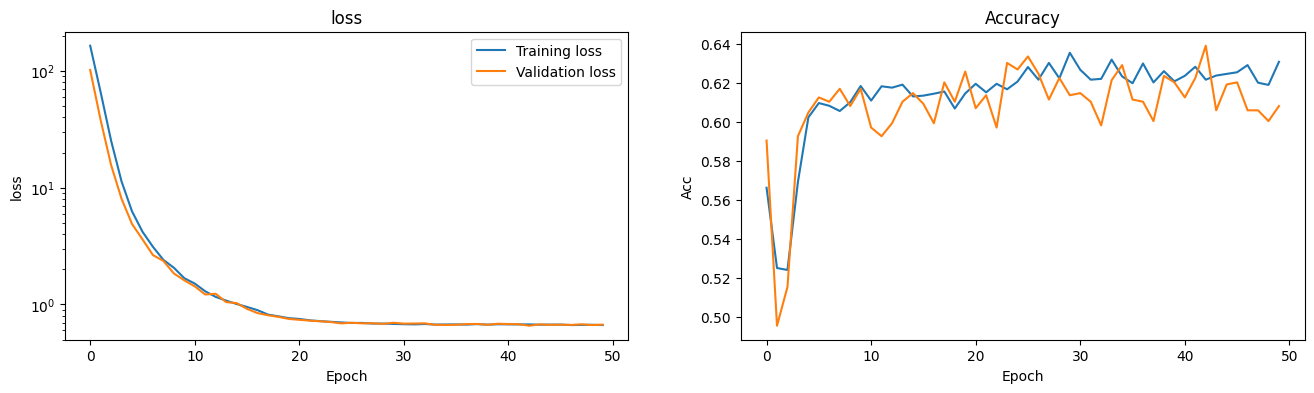

In [24]:
# Look at the optimization history
fig, (ax1,ax2) = plt.subplots(1,2, figsize=plt.figaspect(0.25))
ax1.plot(train_loss, label='Training loss')
ax1.plot(val_loss, label='Validation loss')
ax1.set_yscale('log')
ax1.set_title('loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('loss')
ax1.legend()

ax2.plot(cat_acc, label='Training ACC')
ax2.plot(val_acc, label='Validation ACC')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Acc')
ax2.legend

In [25]:
for j in range(len(climo[0,:])):
    bs = brier_score_loss(Y_all[:,j], pred[:,j])
    bs_ref = brier_score_loss(Y_all[:,j], climo[:,j])
    bss = 1 - (bs / bs_ref)

NameError: name 'climo' is not defined

In [ ]:
import sklearn
pred_class = []
for k in range(len(Y_all[:,0])):##PREDICTIVE
    #print(pred_val[k,0])
    #print(pred_val[k,1])
    #print(pred_val[k,2])
    if pred[k,0] > pred[k,1]:
        #print("a")
        pred_class.append([1.,0.])
    elif pred[k,1] > pred[k,0]:
        #print("b")
        pred_class.append([0.,1.])
prd = np.asarray(pred_class)
for j in range(len(climo[0,:])):
    recal = sklearn.metrics.recall_score(Y_all[:,j], prd[:,j])

In [ ]:
pred_class = []
for k in range(len(Y_all[:,0])):##PREDICTIVE
    #print(pred_val[k,0])
    #print(pred_val[k,1])
    #print(pred_val[k,2])
    if pred[k,0] > pred[k,1]:
        #print("a")
        pred_class.append([1.,0.])
    elif pred[k,1] > pred[k,0]:
        #print("b")
        pred_class.append([0.,1.])
prd = np.asarray(pred_class)
for j in range(len(climo[0,:])):
    prec = sklearn.metrics.precision_score(Y_all[:,j], prd[:,j])

In [ ]:
print("Brier Skill Score: ",bss)
print("Recall Accuracy Score: ",recal)
print("Precision Accuracy Score: ",prec)

In [ ]:
# Creating an analyzer
model_wo_sm = innvestigate.model_wo_softmax(model)
gradient_analyzer = innvestigate.create_analyzer("deep_taylor", model_wo_sm)

# Applying the analyzer
analysis = gradient_analyzer.analyze(X_train)

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
analysis.shape[0]

In [ ]:
#Convert the list to an array to make processing simpler and reshape it into a 2-D map (our inputs were vectorized)
LRP_heatmaps = analysis.reshape(analysis.shape[0], 21, 37)

#Normalize each heatmap to have a maximum value of 1 so all samples can be compared equally
LRP_heatmaps_scaled = LRP_heatmaps/np.nanmax(LRP_heatmaps, axis=(-2,-1))[:,np.newaxis,np.newaxis]

#Now take the mean across all samples to make a composite...
LRP_heatmaps_mean = np.nanmean(LRP_heatmaps_scaled, axis=0)

In [ ]:
LRP_heatmaps_mean.shape

In [ ]:
#lat
lats = np.arange(80, 29.5, -2.5)
#lon
lons = np.arange(-100, -9.5, 2.5)

In [ ]:
# plot the original data 
color = 'BuGn' 
colorbarMin = 0
colorbarMax = 1
colorspace = 0.05
level = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)
ax = plt.axes(projection=ccrs.cartopy.crs.PlateCarree(central_longitude=180))
h = ax.contourf(lons, lats, LRP_heatmaps_mean, level, transform=ccrs.PlateCarree(), cmap=color,extend='both')
#plt.contourf(lons, lats, LRP_heatmaps_mean, level, cmap=color,extend='both')
cbar = plt.colorbar(h, orientation='horizontal', shrink=1,fraction=0.1,pad=0.1,aspect=35)
cbar.ax.tick_params(labelsize=10) 
#Add in the coordinate system:
long = np.arange(-100, -10, 5)
latg = np.arange(80, 30 ,-5)
ax.set_xticks(long, crs=ccrs.PlateCarree());
ax.set_yticks(latg, crs=ccrs.PlateCarree());
ax.set_xticklabels(long,fontsize=8)
ax.set_yticklabels(latg,fontsize=8)
ax.set_ylabel('Latitude',fontsize=10);
ax.set_xlabel('Longitude',fontsize=10);

#Add in the continents
#define the coastlines, the color (#000000) and the resolution (110m) 
feature1 = cf.NaturalEarthFeature(
    name='coastline', category='physical',
    scale='110m',
    edgecolor='#000000', facecolor='none')

ax.add_feature(feature1)

plt.tight_layout()
#Set a title for your map:
title = 'LRP on 500hPa GPH associated with Temp Anomalies over Europe'
plt.title(title,fontsize=10, y=1.03)
#plt.savefig("LRP_take1.png")